# Tutorial: Individual models and plots for an exemplary hospital

---
> **_Note:_** This notebooks show how to re-create Figures 1 and 2 in the manuscript

## Setup 

The following code includes all necessary packages and loads the data. Alternatively, one can run the following commands:
```
cd("../")
path_to_repo = pwd()
include("src/setup.jl"))
```
This loads the `setup.jl` file in the `scr` folder, which automatically includes all required packages and loads the dataset from the `data` folder. 

In [1]:
cd("../")
path_to_repo = pwd()

using Pkg;
Pkg.activate(path_to_repo)
Pkg.instantiate() # install packages in versions specified in the Project.toml file 

# check that required package versions are there 
Pkg.status()

# import packages
using CSV 
using DataFrames
using FileIO
using GLM 
using JLD2
using LinearAlgebra
using ProgressMeter
using Random
using Statistics
using StatsBase
using StatsPlots
using VegaLite
using Zygote 

#load data  
datadict = load("data/data_allhospitals.jld2")
hospital_list = datadict["hospital_dfs"]

path_to_results = string(path_to_repo, "/results/")

 Activating environment at `~/Desktop/DifferentiableProgrammingforStatisticalModeling/GithubRepo/Project.toml`


Status `~/Desktop/DifferentiableProgrammingforStatisticalModeling/GithubRepo/Project.toml`
  [336ed68f] CSV v0.8.5
  [a93c6f00] DataFrames v1.1.1
  [0c46a032] DifferentialEquations v6.18.0
  [5789e2e9] FileIO v1.9.0
  [38e38edf] GLM v1.4.2
  [033835bb] JLD2 v0.4.3
  [91a5bcdd] Plots v1.15.3
  [92933f4c] ProgressMeter v1.7.1
  [2913bbd2] StatsBase v0.33.8
  [f3b207a7] StatsPlots v0.14.21
  [112f6efa] VegaLite v2.6.0
  [e88e6eb3] Zygote v0.6.12
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics


"/Users/imbi-mac-102/Desktop/DifferentiableProgrammingforStatisticalModeling/GithubRepo/results/"

## Visualize the number of reported cases over time 

In the following, we will take a look at an exemplary hospital (the one used to create the Figures 1 and 2 in the manuscript), which can be found at index 40 in our dataset. 

Let's first look at the data. Note that the values shown in `:currentcases` have been imputed based on last-observation-carried-forward whenever a report has been missing, as indicated by a $0$ in the `:reported`column. 

In [19]:
myhospital = hospital_list[40][:,[:date, :currentcases, :reported]]

70×3 DataFrame
 Row │ date        currentcases  reported 
     │ Date…       Float64       Bool     
─────┼────────────────────────────────────
   1 │ 2020-04-16           0.0     false
   2 │ 2020-04-17           0.0      true
   3 │ 2020-04-18           0.0      true
   4 │ 2020-04-19           0.0      true
   5 │ 2020-04-20           2.0      true
   6 │ 2020-04-21           0.0      true
   7 │ 2020-04-22           1.0      true
   8 │ 2020-04-23           2.0      true
   9 │ 2020-04-24           2.0      true
  10 │ 2020-04-25           2.0     false
  11 │ 2020-04-26           3.0      true
  ⋮  │     ⋮            ⋮           ⋮
  61 │ 2020-06-15           2.0      true
  62 │ 2020-06-16           2.0     false
  63 │ 2020-06-17           2.0     false
  64 │ 2020-06-18           2.0      true
  65 │ 2020-06-19           3.0      true
  66 │ 2020-06-20           3.0     false
  67 │ 2020-06-21           3.0     false
  68 │ 2020-06-22           3.0     false
  69 │ 2020-06-23           3.0     false
  70 │ 2020-06-24           3.0     false
                           49 rows omitted

We replace all numbers in `:currentcases` that have been imputed by last-observation-carried-forward with `NaN`, i.e., all values in rows where `:reported` is equal to $0$. 

In [20]:
myhospital[findall(x -> x == false, myhospital[:,:reported]),:currentcases] .= NaN;

Now, we can plot the number of current cases over the time interval, to visualize the missingness pattern:

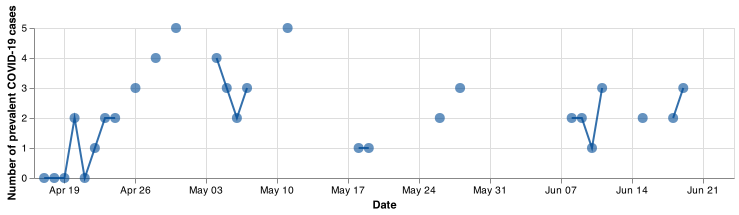

In [21]:
figure1=myhospital|> @vlplot(
        width=700, height=150,
        mark={:line, point={filled=true, size=100, color="#004b96", opacity = 0.6}, color="#004b96", opacity=0.8}, 
        x={field=:date, axis={title="Date"}},
        y={field=:currentcases, axis={title="Number of prevalent COVID-19 cases"}}
) 

We can save the figure to the `results` folder: 

In [22]:
save(string(path_to_results,"Figure1.svg"), figure1)

## Fit the increment model for all hospitals individually

Next, we show how to optimize the increment model and all benchmark models discussed in the manuscript for all hospitals.

First, let's define the loss function, including a loop and control flow elements to automatically bridge missing reports by carrying the current model prediction forwards in time, until a new observation becomes available. 

The loss function is also supplied in the `loss.jl` file in the `src` folder for convenience. It can alternatively by loaded by running 
```
include("src/loss.jl") 
```

In [23]:
function loss(y, z, r, beta)
    sqerror = 0.0 # squared error
    firstseen = false # set to true after skipping potential missings 
    last_y = 0.0 # prevalent cases from previous time point
    contribno = 0.0 # number of non-missing observations

    for t = 1:length(y)
        # skip missings at the start until first reported value
        if !firstseen 
            if r[t] == 1
                firstseen = true
                last_y = y[t]
            else
                continue
            end
        else # make a prediction for the current increment
            pred_dy = beta[1] + beta[2] * last_y + beta[3] * z[t-1] 
            if r[t] == 1
                dy = y[t] - last_y
                sqerror += (dy - pred_dy)^2
                contribno += 1.0
                last_y = y[t]
            else
                last_y += pred_dy
            end 
        end
    end
    return sqerror/contribno # return MSE over all reported time points end
end

loss (generic function with 1 method)

For each hospital, we need to extract the necessary data, i.e., the numbers of prevalent cases and predicted incidences used as covariates and the information on whether or not a report was missing. 

Then, we can use differentiable programming to optimize the model parameters by optimizing this loss function via gradient descent!

In [26]:
y, z, r = hospital_list[40][1:end-1,:currentcases], hospital_list[40][1:end-1,:incidences], hospital_list[40][1:end-1,:reported]

([0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0  …  3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0], [1.4711, 1.43565, 1.40025, 1.3652, 1.33085, 1.29735, 1.26475, 1.2332, 1.20275, 1.1737  …  0.28005, 0.27605, 0.27275, 0.27025, 0.2685, 0.2675, 0.2673, 0.26795, 0.26945, 0.27195], Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 0  …  0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

We set aside the last time point in the data to evaluate our prediction on: 

In [27]:
last_currentcases, lastreported = hospital_list[40][end,:currentcases], hospital_list[40][end,:reported]

(3.0, false)

We are now ready to use differentiable programming to optimize the model parameters by optimizing this loss function via gradient descent!

In [28]:
beta = [0.0, 0.0, 0.0]
for epoch=1:1000
    curgrad = gradient(arg -> loss(y, z, r, arg), beta)
    beta .-= [0.001, 0.01, 0.001] .* curgrad[1]
    if epoch%100 == 0
        @info "current loss value:" loss(y, z, r, beta)
    end
end

┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.3037878612612999
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.2076401103486583
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.158098481928824
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.129995239294433
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.113148987526312
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.1026904745265005
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.0960413134567757
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.0917419154002272
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.0889271059084553
└ @ Main In[28]:6
┌ Info: current loss value:
│   loss(y, z, r, beta) = 1.0870668828293453
└ @ Main In[28]:6


Now, we can do this for all hospitals, and compare the different benchmark models and their prediction errors. 

For this, we first initialize the parameters `betas` and `lrbetas` for both the increment model and the standard linear regression model estimated via classical maximum likelihood. 

In [29]:
nhospitals = length(hospital_list)

betas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals)
lrbetas = collect([0.0; 0.0; 0.0] for i in 1:nhospitals);

For each model, we also initialize an array for the predictions from this model for each hospital.  

In [30]:
prederrs_mean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_modmean = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_zero = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_linreg = Array{Union{Float64, Missing}}(missing, nhospitals)
prederrs_incrmod = Array{Union{Float64, Missing}}(missing, nhospitals);

Now, we optimize our model for all hospitals and compare the predictions to the baseline models.

In [32]:
@showprogress for i = 1:nhospitals
    # get the covariates and info about missing reports
    y, z, r = hospital_list[i][1:end-1,:currentcases], hospital_list[i][1:end-1,:incidences], hospital_list[i][1:end-1,:reported]
    last_currentcases, lastreported = hospital_list[i][end,:currentcases], hospital_list[i][end,:reported]

    # run the gradient descent via automatic differentiation/differentiable programming
    beta = betas[i]
    for epoch=1:150
        curgrad = gradient(arg -> loss(y, z, r, arg), beta)
        beta .-= [0.001, 0.01, 0.001] .* curgrad[1]
    end
    betas[i] = beta

    # calculate last increment based on the held-out final time point 
    lastincr = last_currentcases - y[end]

    # calculate the prediction of the fitted models for this last increment
    incrmod_pred = beta[1] + beta[2] * y[end] + beta[3] * z[end]

    # calculate the prediction of the mean and modified mean models
    mean_pred = mean(diff(y))
    modmean_pred = y[end] == 0.0 ? 0.0 : mean_pred

    # coarse heuristic: if the fit goes wrong, use the mean model prediction as fallback
    if isnan(incrmod_pred) || any(abs.(beta) .> 10)
        incrmod_pred = mean_pred
    end

    # fit standard linear regression model using the last-observation-carried-forward imputation in the :currentcases
    slrdf = DataFrame(dy = diff(y), y = y[2:end], z = z[2:end])
    ols = lm(@formula(dy ~ y + z), slrdf) # standard estimation using maximum likelihood
    lrbeta = coef(ols) 
    lrbetas[i] = lrbeta
    # calculate prediction of the standard linear regression model for the last increment 
    linreg_pred = lrbeta[1] + lrbeta[2] * y[end] + lrbeta[3] * z[end]

    # include in the prediction error array only if the value at the last time point has actually been reported
    if lastreported 
        prederrs_mean[i] = (lastincr - mean_pred)^2
        prederrs_modmean[i] = (lastincr - modmean_pred)^2
        prederrs_zero[i] = (lastincr - 0)^2
        prederrs_linreg[i] = (lastincr - linreg_pred)^2
        prederrs_incrmod[i] = (lastincr - incrmod_pred)^2
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


We can now combine the prediction errors for all models in a dataframe.

In [33]:
nonmissinginds = findall(x -> !ismissing(x), prederrs_mean)
prederrs_df = DataFrame(hospitals = nonmissinginds,
                meanmodel = Float64.(prederrs_mean[nonmissinginds]),
                modmeanmodel = Float64.(prederrs_modmean[nonmissinginds]),
                zeromodel = Float64.(prederrs_zero[nonmissinginds]),
                linregmodel = Float64.(prederrs_linreg[nonmissinginds]),
                incrmodel = Float64.(prederrs_incrmod[nonmissinginds])
)

1231×6 DataFrame
  Row │ hospitals  meanmodel    modmeanmodel  zeromodel  linregmodel  incrmode ⋯
      │ Int64      Float64      Float64       Float64    Float64      Float64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         1  0.0           0.0                0.0  0.0          0.0      ⋯
    2 │         2  0.000216263   0.000216263        0.0  0.000510627  0.000217
    3 │         3  0.000865052   0.0                0.0  0.000638768  0.000698
    4 │         4  0.0           0.0                0.0  0.0          0.0
    5 │         5  0.0           0.0                0.0  0.0          0.0      ⋯
    6 │         6  0.0           0.0                0.0  0.0          0.0
    7 │         7  0.0           0.0                0.0  1.32536e-5   7.02648e
    8 │         8  0.0           0.0                0.0  0.0120506    6.66167e
    9 │         9  0.000216263   0.0                0.0  0.000774628  9.28607e ⋯
   10 │        10  0.000216263   0.0                0.0  0.000383576  5.51986e
   11 │        11  0.00346021    0.0                0.0  0.0610118    0.000129
  ⋮   │     ⋮           ⋮            ⋮            ⋮           ⋮            ⋮   ⋱
 1222 │      1272  0.0423875     0.0423875          0.0  0.12975      0.042387
 1223 │      1273  0.0           0.0                0.0  0.0          0.0      ⋯
 1224 │      1274  0.0175173     0.0175173          0.0  0.0518235    0.017517
 1225 │      1275  0.437933      0.437933           1.0  0.947681     0.437933
 1226 │      1276  0.858348      0.858348           1.0  0.664153     0.952891
 1227 │      1277  0.0           0.0                0.0  0.0          0.0      ⋯
 1228 │      1278  0.000216263   0.0                0.0  0.00133999   0.000447
 1229 │      1279  0.0175173     0.0                0.0  0.313537     0.009602
 1230 │      1280  0.000216263   0.0                0.0  0.0513739    5.90152e
 1231 │      1281  0.0           0.0                0.0  0.0          0.0      ⋯
                                                  1 column and 1210 rows omitted

Based on this, we can now calculate the summary statistics as reported in the manuscript. 

In [34]:
models = names(prederrs_df[!,2:end])
summed_squared_errors = sum.(eachcol(prederrs_df[!,2:end]))
mses = round.(sum.(eachcol(prederrs_df[!,2:end]))./(nrow(prederrs_df)), digits=3)
medians = round.(median.(eachcol(prederrs_df[!,2:end])), digits=3)
firstquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.25), digits=3)
thirdquartile = round.(quantile.(eachcol(prederrs_df[!,2:end]), 0.75), digits=3)
maxvals = round.(maximum.(eachcol(prederrs_df[!,2:end])), digits=3)
sqerr_df = DataFrame(Model = models, 
                    SSE = summed_squared_errors, MSE = mses, 
                    FirstQuartile = firstquartile,
                    Median = medians, 
                    ThirdQuartile = thirdquartile,
                    Maximum = maxvals
)

5×7 DataFrame
 Row │ Model         SSE       MSE      FirstQuartile  Median   ThirdQuartile  ⋯
     │ String        Float64   Float64  Float64        Float64  Float64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ meanmodel      89.2388    0.072            0.0    0.0            0.002  ⋯
   2 │ modmeanmodel   84.3421    0.069            0.0    0.0            0.0
   3 │ zeromodel      86.0       0.07             0.0    0.0            0.0
   4 │ linregmodel   181.068     0.147            0.0    0.001          0.015
   5 │ incrmodel      74.7457    0.061            0.0    0.0            0.001  ⋯
                                                                1 column omitted

We can save this to the `results` folder.

In [35]:
CSV.write(string(path_to_results, filename, ".csv"), sqerr_df)

"/Users/imbi-mac-102/Desktop/DifferentiableProgrammingforStatisticalModeling/GithubRepo/results/filename.csv"

For convenience, we have written function `create_prederrs_df` and `get_summary_df` that automatically combine the prediction arrays and calculate the summary statistics as shown above. Th

These functions are saved in the `evaluate.jl` file in the `src` folder and can be loaded by running 

In [36]:
include("src/evaluate.jl")

get_summary_df (generic function with 1 method)

Now, the code above can be simplified to the following lines: 

In [37]:
prederrs_df = create_prederrs_df(prederrs_mean, prederrs_modmean, prederrs_zero, prederrs_linreg, prederrs_incrmod)
summary_df = get_summary_df(prederrs_df, save_csv=true, path_to_results = path_to_results, filename="prederr_stats_localmodels")

5×7 DataFrame
 Row │ Model         SSE       MSE      FirstQuartile  Median   ThirdQuartile  ⋯
     │ String        Float64   Float64  Float64        Float64  Float64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ meanmodel      89.2388    0.072            0.0    0.0            0.002  ⋯
   2 │ modmeanmodel   84.3421    0.069            0.0    0.0            0.0
   3 │ zeromodel      86.0       0.07             0.0    0.0            0.0
   4 │ linregmodel   181.068     0.147            0.0    0.001          0.015
   5 │ incrmodel      74.7457    0.061            0.0    0.0            0.001  ⋯
                                                                1 column omitted

Additionally, we can visualize the error distribution in a boxplot as follows: 

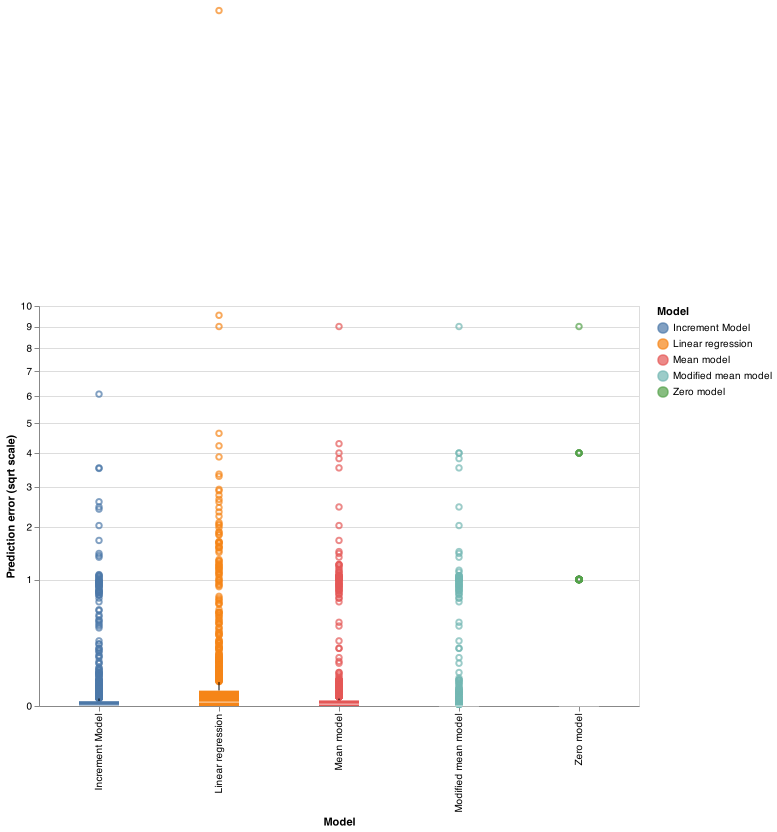

In [38]:
rename!(prederrs_df, ["linregmodel" => "Linear regression", "meanmodel" => "Mean model", "incrmodel" => "Increment Model",
                        "modmeanmodel" => "Modified mean model", "zeromodel" => "Zero model"])
stacked_df = stack(prederrs_df)
boxplot_localmodels = stacked_df |> @vlplot(
    width=600, height=400,
    mark={:boxplot, extend=2},
    x = {"variable:o", title="Model"},
    y = {"value", scale={type="sqrt", domain=[0,10]}, axis = 0:0.5:10, title="Prediction error (sqrt scale)"}, # one outlier for linear regression removed
    color = {:variable, title="Model"},
    size={value=40}
)

We can save it if we want:

In [39]:
save(string(path_to_results, "boxplot_localmodels.svg"), boxplot_localmodels)

## Visualize the results based on model fitting on shorter time intervals and with different combinations of global and individual parameters

The visualization is based on the estimated parameters for all time intervals and all combinations of global and individual parameters. These are provided in the `results` folder or can alternatively be generated by running the script `SensitivityAnalysisTemporalSubsets.jl` in the `scripts` folder. Since it takes a few hours to run unless heavily parallelized due to the large number of models that have to be estimated, we included the resulting parameters for convenience, so they can be directly loaded. 

First, we need some definitions related to the number of time points and temporal subsets.

In [50]:
ntimepoints = length(hospital_list[1][!,:date])
lateststart = Int(floor(ntimepoints/2))
nresamples = lateststart +1
nsampletimepoints = lateststart

35

Again, we consider the exemplary hospital $40$ from the beginning and start by loading the respective data 

In [51]:
i=40
df = hospital_list[i]
y, z, r = df[1:end-1,:currentcases], df[1:end-1,:incidences], df[1:end-1,:reported]

([0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0  …  3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0], [1.4711, 1.43565, 1.40025, 1.3652, 1.33085, 1.29735, 1.26475, 1.2332, 1.20275, 1.1737  …  0.28005, 0.27605, 0.27275, 0.27025, 0.2685, 0.2675, 0.2673, 0.26795, 0.26945, 0.27195], Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 0  …  0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

We now load the estimated coefficients based on the model fitted on the complete dataset, which can be found in the `results` folder or alternatively generated by running the script `GlobalvsIndividualParameters.jl` in the `scripts` folder. 

In [42]:
betas_all_combs_dict = load(string(path_to_results, "betas_allcombinations.jld2"))
betas_all_combs = betas_all_combs_dict["betas_allcombinations"];

Next, for each combination of global vs. local estimation, we load the estimated parameters from each temporal subset of the data for the specific exemplary hospital and combine them into one array. 

In [48]:
#path_to_results = "/Users/imbi-mac-102/Desktop/DifferentiableProgrammingforStatisticalModeling/Code/results/"
combinations = [["global", "global", "global"],
                ["global", "global", "individual"],
                ["global", "individual", "global"],
                ["global", "individual", "individual"],
                ["individual", "global", "global"],
                ["individual", "global", "individual"],
                ["individual", "individual", "global"],
                ["individual", "individual", "individual"]
]

allbetas = []
betas_alldata = []
for cind in 1:length(combinations)
    combination = combinations[cind]
    beta1, beta2, beta3 = combination[1], combination[2], combination[3]

    push!(betas_alldata, betas_all_combs["combination_$(beta1)_$(beta2)_$(beta3)"][i])

    inds_in_dfs_resamples_dict = load(string(path_to_results, "inds_in_dfs_allresamples_combination$(cind).jld2"))
    inds_in_dfs_allresamples = inds_in_dfs_resamples_dict["inds_resamples_combination$(cind)"]

    betas_dict = load(string(path_to_results, "betas_allresamples_combination$(cind).jld2"))
    betas_allresamples = betas_dict["betas_resamples_combination$(cind)"];
    push!(allbetas, collect(betas_allresamples[resample][findall(x -> x == 40,inds_in_dfs_allresamples[resample])[1]] for resample in 1:nresamples))
end

Now, we can create a plot for each combination of global and individual parameter estimation that overlays the reconstructed trajectories based on the parameters estimated on all temporal subsets of the data. 

┌ Info: starting with combination 1
└ @ Main In[52]:2


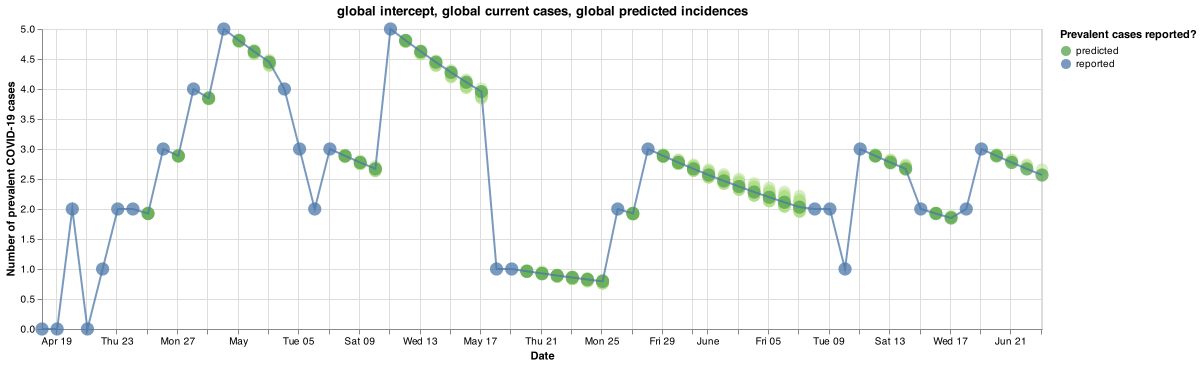

┌ Info: starting with combination 2
└ @ Main In[52]:2


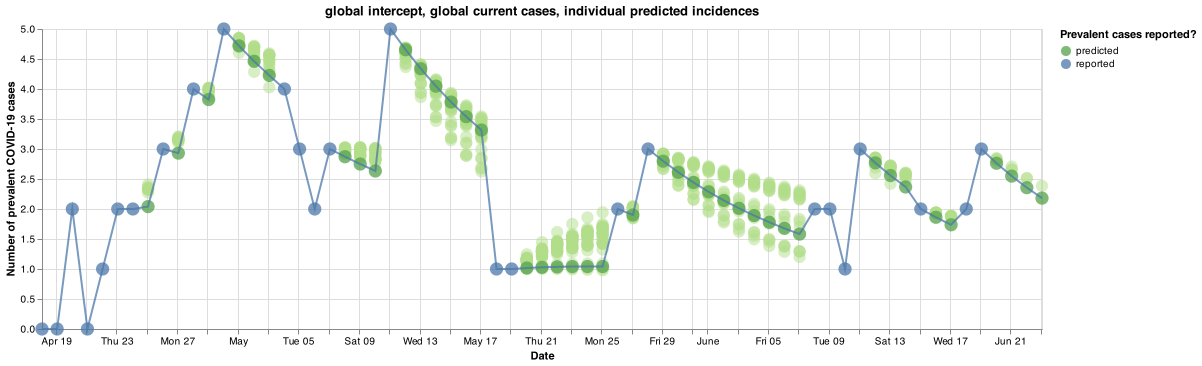

┌ Info: starting with combination 3
└ @ Main In[52]:2


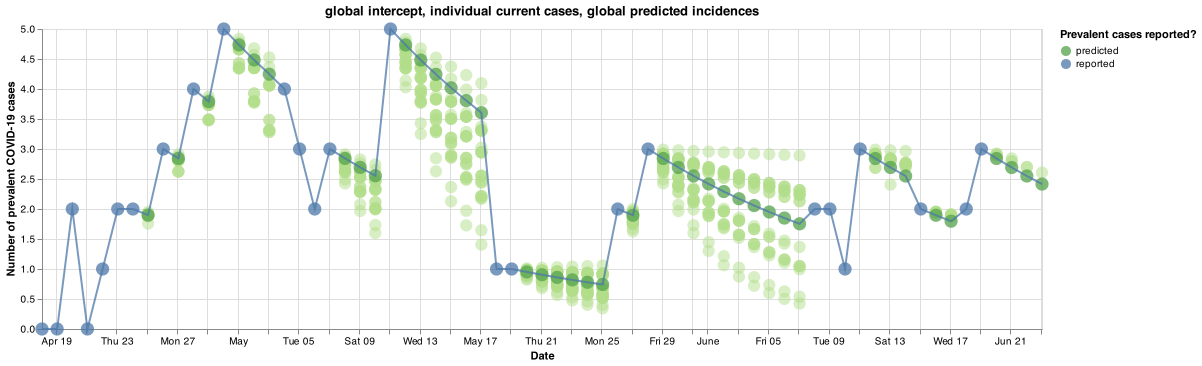

┌ Info: starting with combination 4
└ @ Main In[52]:2


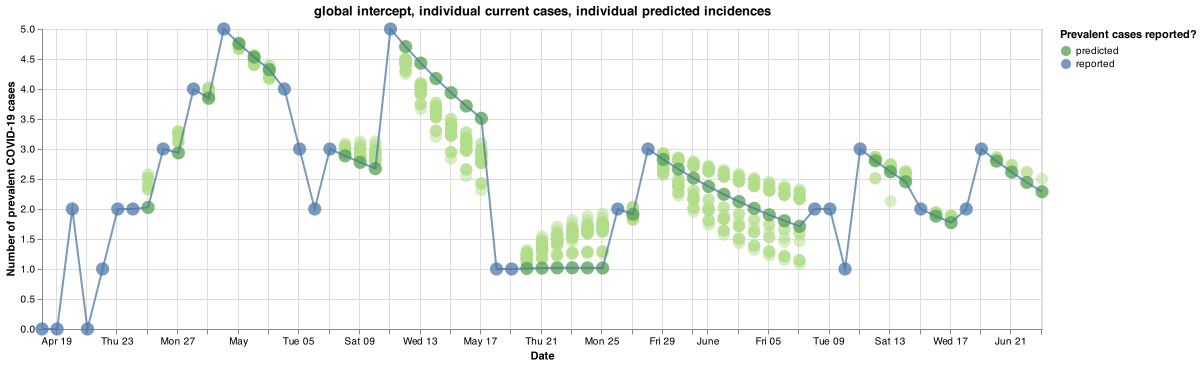

┌ Info: starting with combination 5
└ @ Main In[52]:2


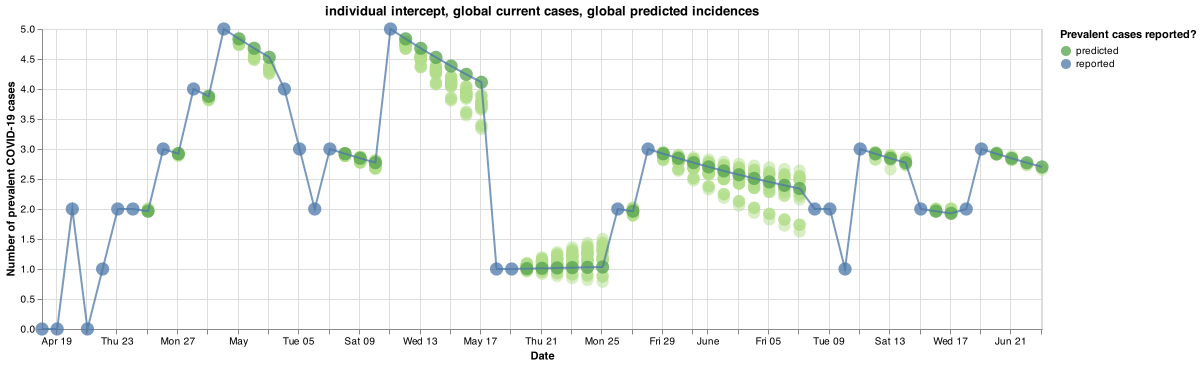

┌ Info: starting with combination 6
└ @ Main In[52]:2


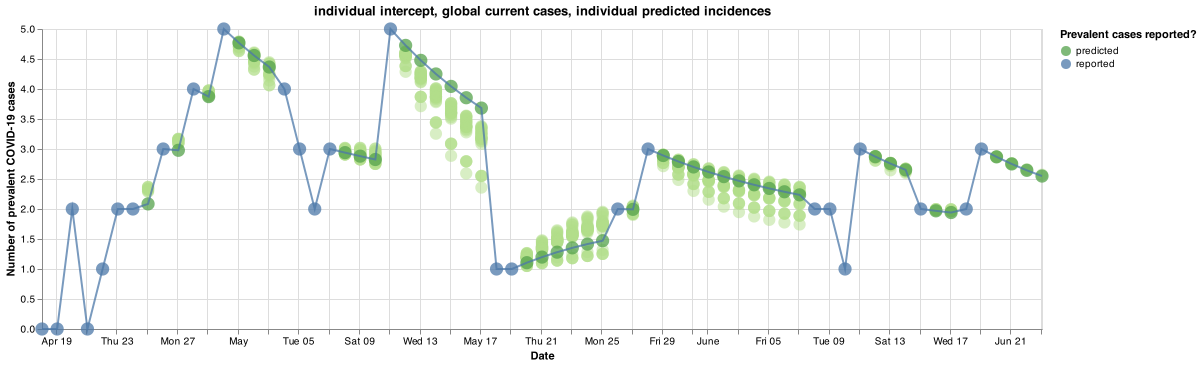

┌ Info: starting with combination 7
└ @ Main In[52]:2


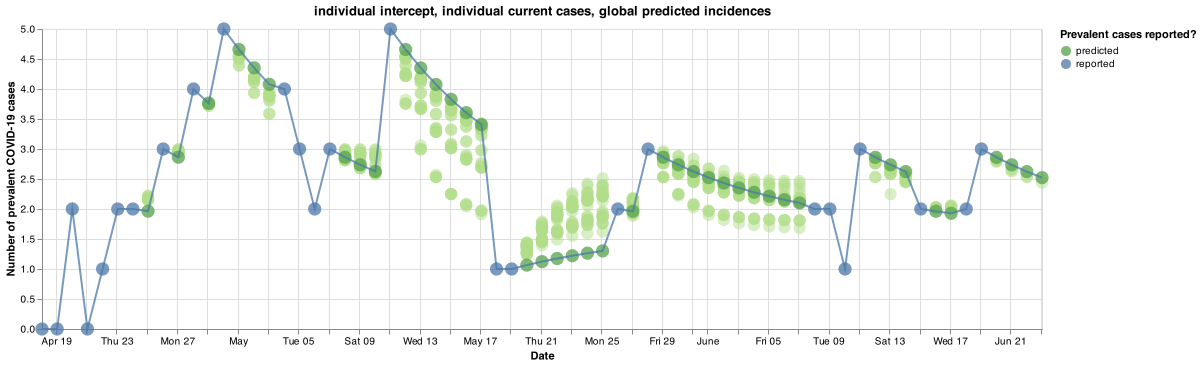

┌ Info: starting with combination 8
└ @ Main In[52]:2


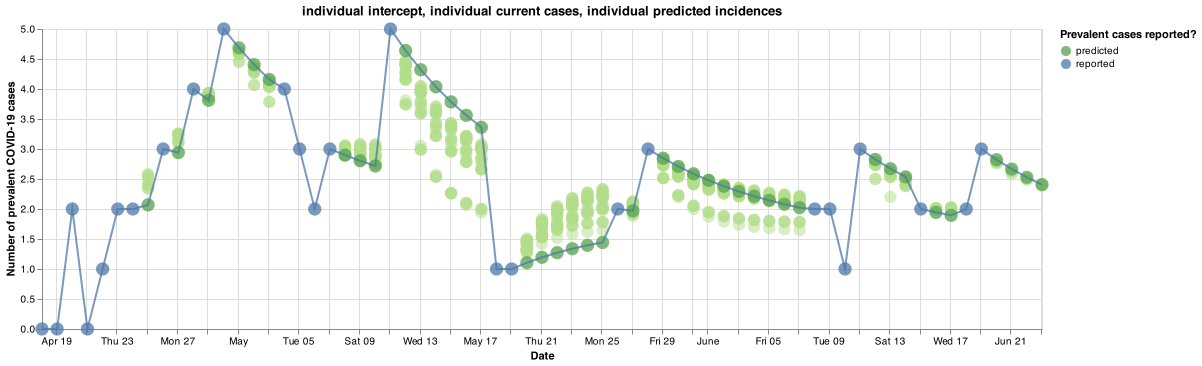

In [52]:
for cind in 1:length(combinations)
    @info "starting with combination $(cind)"
    combination = combinations[cind]
    beta1, beta2, beta3 = combination[1], combination[2], combination[3]

    beta_alldata = betas_alldata[cind]
    pred_traj = getpredictedtrajectory(y, z, r, beta_alldata)
    pred_df_all = DataFrame(date =  df[findfirst(x -> x, df[:,:reported])+1:(end-1),:date],
                    predicted_cases = pred_traj,
                    notreported = df[findfirst(x -> x, df[:,:reported])+1:(end-1),:notreported]
    )
    p = pred_df_all |> @vlplot(width = 1000, height = 300, 
                    transform = [{calculate = "datum.notreported == true ? 'predicted' : 'reported'",
                                as = "casesreported"}]) 
    @vlplot(
            mark = {:point, filled=true, size=175, opacity=0.75},
            x = {:date, title = "Date"},
            y = {"predicted_cases:q", title = "Number of prevalent COVID-19 cases"},
            color = {"casesreported:n",
                    scale = {range = ["#54a24b", "#4c78a8"]},
                    legend = {title = "Prevalent cases reported?"}
                    }
        ) +
        @vlplot(
            mark = {:line, color = "#4c78a8", opacity = 0.75},
            x = {"date:t", title = "Date"},
            y = {"predicted_cases:q", title = "Number of prevalent COVID-19 cases"}
    )
    for resample in 1:nresamples 
        resamplerange = resample:resample+nsampletimepoints-1
        resample_df = df[resamplerange,:]
        cur_beta = allbetas[cind][resample]
        cur_y, cur_z, cur_r = resample_df[1:end-1,:currentcases], resample_df[1:end-1,:incidences], resample_df[1:end-1,:reported]
        pred_traj = getpredictedtrajectory(cur_y, cur_z, cur_r, cur_beta)
        pred_df = DataFrame(date =  resample_df[findfirst(x -> x, resample_df[:,:reported])+1:(end-1),:date],
                            predicted_cases = pred_traj,
                            notreported = resample_df[findfirst(x -> x, resample_df[:,:reported])+1:(end-1),:notreported]
        )
        p = p + @vlplot(data = pred_df[pred_df[!,:notreported].== true,:],
            mark = {:point, filled=true, size=150, opacity=0.5, color = "#b2df8a"},
            x = {:date, title = "Date"},
            y = {"predicted_cases:q", title = "Number of prevalent COVID-19 cases"}
        )
    end
    p = p + @vlplot(
        data=pred_df_all,
        transform = [{calculate = "datum.notreported == true ? 'predicted' : 'reported'",
                                as = "casesreported"}],
        mark = {:point, filled=true, size=175, opacity=0.75},
        x = {:date, title = "Date"},
        y = {"predicted_cases:q", title = "Number of prevalent COVID-19 cases"},
        color = {"casesreported:n",
            scale = {range = ["#54a24b", "#4c78a8"]},
            legend = {title = "Prevalent cases reported?"}
            }
        ) +
    @vlplot(data=pred_df_all,
        title = "$(beta1) intercept, $(beta2) current cases, $(beta3) predicted incidences",
        mark = {:line, color = "#4c78a8", opacity = 0.75},
        x = {"date:t", title = "Date"},
        y = {"predicted_cases:q", title = "Number of prevalent COVID-19 cases"}
    )
    display(p)
    p |> save(string(path_to_results,"predicted_cases_hospital$(i)_combination_$(cind).svg"))
end